In [1]:
import numpy as np
import os

import sys
from pycox import datasets
from lifelines.datasets import load_rossi
from sksurv.datasets import (
    load_aids,
    load_breast_cancer,
    load_flchain,
    load_gbsg2,
    load_whas500,
)
from sklearn.preprocessing import LabelEncoder
import synthcity.logger as log
from medicaldata.CUTRACT import download as cutract_download, load as cutract_load
from medicaldata.SEER_prostate_cancer import download as seer_download, load as seer_load
from medicaldata.MAGGIC import download as maggic_download, load as maggic_load
from medicaldata.NCRAS import download as ncras_download, load as ncras_load
from pathlib import Path

log.add(sink=sys.stderr, level="INFO")

def get_dataset(name: str):
    if name == "metabric":
        df = datasets.metabric.read_df()
    elif name == "support":
        df = datasets.support.read_df()
    elif name == "gbsg":
        df = datasets.gbsg.read_df()
    elif name == "rossi":
        df = load_rossi()
        df = df.rename(columns={"week": "duration", "arrest": "event"})
    elif name == "aids":
        X, Y = load_aids()
        Y_unp = np.array(Y, dtype=[("event", "int"), ("duration", "float")])
        df = X.copy()
        df["event"] = Y_unp["event"]
        df["duration"] = Y_unp["duration"]
    elif name == "flchain":
        X, Y = load_flchain()
        Y_unp = np.array(Y, dtype=[("event", "int"), ("duration", "float")])
        df = X.copy()
        df["event"] = Y_unp["event"]
        df["duration"] = Y_unp["duration"]
    elif name == "gbsg2":
        X, Y = load_gbsg2()
        Y_unp = np.array(Y, dtype=[("event", "int"), ("duration", "float")])
        df = X.copy()
        df["event"] = Y_unp["event"]
        df["duration"] = Y_unp["duration"]
    elif name == "whas500":
        X, Y = load_whas500()
        Y_unp = np.array(Y, dtype=[("event", "int"), ("duration", "float")])
        df = X.copy()
        df["event"] = Y_unp["event"]
        df["duration"] = Y_unp["duration"]
    elif name == "cutract":
        file_id = "1mew1S3-N2GdVu5nGjaqmpLo7sTKRf4Vj"
        csv_path = Path("data/cutract.csv")
        if not csv_path.exists():
            cutract_download(file_id, csv_path)
 
        X, T, Y = cutract_load(csv_path, preprocess = False)
        df = X.copy()
        df["event"] = Y
        df["duration"] = T
        
    elif name == "seer":
        file_id = "1PNXLjy8r1xHZq7SspduAMK6SGUTvuwM6"

        csv_path = Path("data/seer.csv")
        if not csv_path.exists():
            seer_download(file_id, csv_path)
 
        X, T, Y = seer_load(csv_path, preprocess = False)
        df = X.copy()
        df["event"] = Y
        df["duration"] = T
    elif name == "maggic":
        file_id = "19Zvlxid9apEfI6dxuIrygOJCpckQVnX3"

        csv_path = Path("data/maggic.csv")
        if not csv_path.exists():
            maggic_download(file_id, csv_path)
 
        X, T, Y = maggic_load(csv_path, preprocess = False)
        df = X.copy()
        df["event"] = Y
        df["duration"] = T
    elif name == "ncras_bc":
        file_id = "13BiNTv4koBfYAqKbXuQ2ORKNBelQjAYx"

        csv_path = Path("data/ncras_bc.csv")
        if not csv_path.exists():
            ncras_download(file_id, csv_path)
 
        X, T, Y = ncras_load(csv_path, preprocess = False)
        df = X.copy()
        df["event"] = Y
        df["duration"] = T
        
    for col in df.columns:
        if df[col].dtype.name in ["object", "category"]:
            df[col] = LabelEncoder().fit_transform(df[col])

    duration_col = "duration"
    event_col = "event"

    df = df.fillna(0)
    
    T = df[duration_col]
    
    time_horizons = np.linspace(T.min(), T.max(), num=5)[1:-1].tolist()

    return df, duration_col, event_col, time_horizons

In [2]:
from synthcity.plugins import Plugins
from synthcity.benchmark import Benchmarks

plugins = Plugins().list(skip_debug = True)

plugins

['bayesian_network',
 'survival_bayesian_network',
 'survival_adsgan',
 'tvae',
 'ctgan',
 'copulagan',
 'survival_tvae',
 'survival_ctgan',
 'marginal_distributions',
 'nflow',
 'survival_nflow',
 'gaussian_copula',
 'survival_gan',
 'pategan',
 'privbayes',
 'rtvae',
 'adsgan']

In [3]:
plugins = [
    'survival_gan',
]
repeats = 3

In [4]:
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
import pandas as pd
from synthcity.plugins.models.time_to_event.loader import get_model_template
from synthcity.plugins import Plugins
import cloudpickle
from synthcity.utils.serialization import save_to_file, load_from_file
from sklearn.model_selection import train_test_split
from pathlib import Path

out_dir = Path("output")

def plot_survival(title: str,
                  T, E, preds, 
                  ci_show: bool = True,
                  ci_alpha: float = 0.2,
                 ):
    gt_kmf = KaplanMeierFitter()
    gt_kmf.fit(T, E, label = "Real data") # t = Timepoints, Rx: 0=censored, 1=event
    ax = gt_kmf.plot(ci_show = ci_show, ci_alpha = ci_alpha)

    for syn_label, syn_T, syn_E in preds:
        syn_kmf = KaplanMeierFitter()
        syn_kmf.fit(syn_T, syn_E, label = syn_label) # t = Timepoints, Rx: 0=censored, 1=event
        ax = syn_kmf.plot(ax=ax, ci_show = ci_show, ci_alpha = ci_alpha)

    ax.axvline(T[E == 1].max(), color='r', linestyle = "--") # vertical

    plt.title(title)
    plt.show()

def plot_survival_grouped(title: str,
                  T, E, preds, 
                  ci_show: bool = True,
                  ci_alpha: float = 0.2,
                 ):
    fig, axs = plt.subplots(1, len(preds), figsize=(4 * len(preds), 3), constrained_layout = True)
    
    models = []
    for idx, pred in enumerate(preds):
        ax = axs[idx]
        syn_label, syn_T, syn_E = pred
        print("label", syn_label)
        gt_kmf = KaplanMeierFitter()
        gt_kmf.fit(T, E, label = "Real data") # t = Timepoints, Rx: 0=censored, 1=event
        ax = gt_kmf.plot(ax = ax, ci_show = ci_show, ci_alpha = ci_alpha)

        syn_kmf = KaplanMeierFitter()
        syn_kmf.fit(syn_T, syn_E, label = syn_label) # t = Timepoints, Rx: 0=censored, 1=event
        syn_kmf.plot(ax=ax, ci_show = ci_show, ci_alpha = ci_alpha)

        ax.axvline(T[E == 1].max(), color='r', linestyle = "--") # vertical
        ax.set_xlabel("", fontsize = 14)
    
        ax.set_xlabel('Time', horizontalalignment='center', fontsize = 14)
        ax.set_title(title)
        models.append(syn_label.split(":")[1])
        
    models = "_".join(models).replace(" ", "_")
          
    axs[0].set_ylabel("Event probability", fontsize = 14)
        
    plt.savefig(f"diagrams/group_diagram_{title}_{models}.png")
    plt.show()   

def plot_dataset_perf_baselines(
    dataset: str, 
    models: list, 
    individual: bool = True, 
    ci_show: bool = True,
    ci_alpha: float = 0.2
):
    models = sorted(models)
    
    df, duration_col, event_col, time_horizons = get_dataset(dataset)

    Xcov = df.drop(columns = [duration_col, event_col])
    T = df[duration_col]
    E = df[event_col]
    
    X_train, X_test, T_train, T_test, E_train, E_test = train_test_split(Xcov, T, E, stratify = E)

    preds = []
    for ref in models:
        model_bkp = out_dir / f"{dataset}_{ref}"
    
        if model_bkp.exists():
            local_data = load_from_file(model_bkp)
        else:
            syn_model = Plugins().get(ref)

            syn_model.fit(df)

            syn_df = syn_model.generate(len(df))

            syn_T = syn_df[duration_col]
            syn_E = syn_df[event_col]

            label = f"Synthetic: {ref}"

            local_data = (label, syn_T, syn_E)
            
            save_to_file(model_bkp, local_data)
            
        if individual:
            plot_survival(dataset, T, E, [local_data], ci_show = ci_show, ci_alpha = ci_alpha)
        else:
            preds.append(local_data)
    if not individual:
        #plot_survival(dataset, T, E, preds, ci_show = ci_show, ci_alpha = ci_alpha)
        plot_survival_grouped(dataset, T, E, preds, ci_show = ci_show, ci_alpha = ci_alpha)

In [5]:
baseline_models = ["ctgan", "tvae", "privbayes"]
survival_models = ["survival_gan", "survival_tvae", "survival_ctgan",]


label Synthetic: ctgan
label Synthetic: privbayes
label Synthetic: tvae


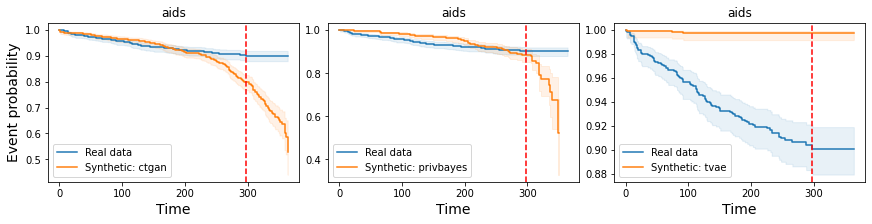

In [6]:
plot_dataset_perf_baselines("aids", 
                           models = baseline_models, 
                           individual = False,
                           ci_alpha = 0.1,
                           )

label Synthetic: ctgan
label Synthetic: privbayes
label Synthetic: tvae


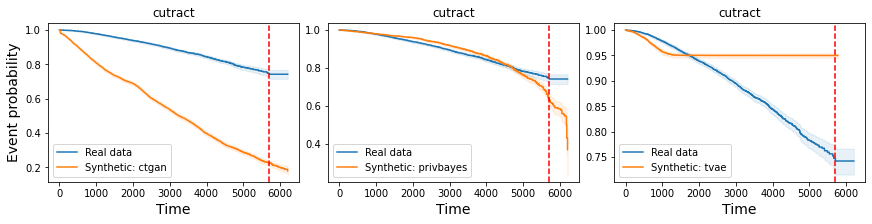

In [7]:
plot_dataset_perf_baselines("cutract", 
                           models = baseline_models, 
                           individual = False,
                           ci_alpha = 0.1,
                           )

label Synthetic: ctgan
label Synthetic: privbayes
label Synthetic: tvae


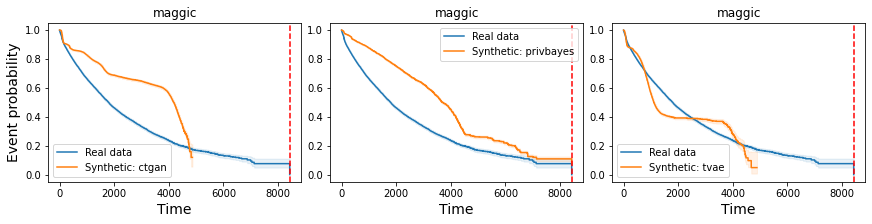

In [8]:
plot_dataset_perf_baselines("maggic", 
                           models = baseline_models, 
                           individual = False,
                           ci_alpha = 0.1,
                           )

label Synthetic: ctgan
label Synthetic: privbayes
label Synthetic: tvae


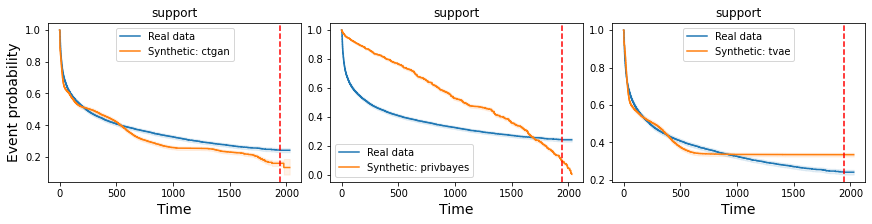

In [9]:
plot_dataset_perf_baselines("support", 
                           models = baseline_models, 
                           individual = False,
                           ci_alpha = 0.1,
                           )

label Synthetic: ctgan
label Synthetic: privbayes
label Synthetic: tvae


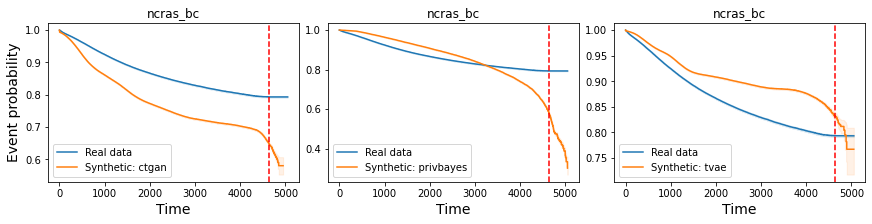

In [10]:
plot_dataset_perf_baselines("ncras_bc", 
                           models = baseline_models, 
                           individual = False,
                           ci_alpha = 0.1,
                           )

label Synthetic: ctgan
label Synthetic: privbayes
label Synthetic: tvae


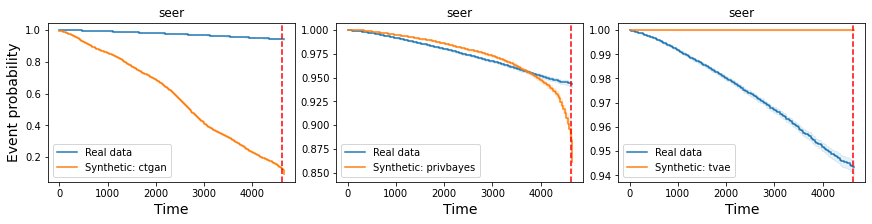

In [11]:
plot_dataset_perf_baselines("seer", 
                           models = baseline_models, 
                           individual = False,
                           ci_alpha = 0.1,
                           )

label Synthetic: survival_ctgan
label Synthetic: survival_gan
label Synthetic: survival_tvae


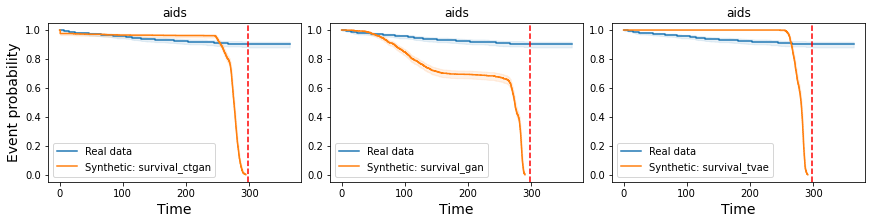

In [12]:
plot_dataset_perf_baselines("aids", 
                           models = survival_models, 
                           individual = False,
                           ci_alpha = 0.1,
                           )

label Synthetic: survival_ctgan
label Synthetic: survival_gan
label Synthetic: survival_tvae


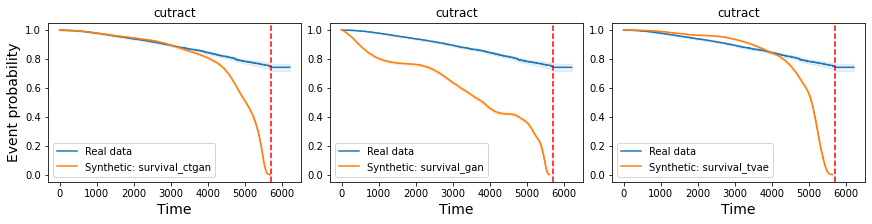

In [13]:
plot_dataset_perf_baselines("cutract", 
                           models = survival_models, 
                           individual = False,
                           ci_alpha = 0.1,
                           )

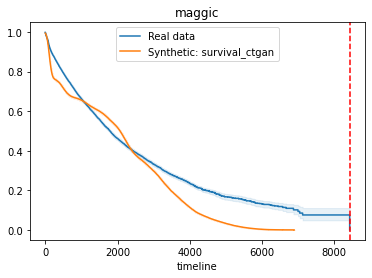

[2022-05-09T11:40:09.778553+0300][1579335][INFO] Evaluate uncensoring for 4977903805384426992
[2022-05-09T11:40:09.936631+0300][1579335][ERROR] fold failed This model does not allow for non-positive durations. Suggestion: add a small positive value to zero elements.
[2022-05-09T11:40:10.056926+0300][1579335][ERROR] fold failed This model does not allow for non-positive durations. Suggestion: add a small positive value to zero elements.
[2022-05-09T11:40:10.212139+0300][1579335][ERROR] fold failed This model does not allow for non-positive durations. Suggestion: add a small positive value to zero elements.
[2022-05-09T11:40:10.315507+0300][1579335][ERROR] fold failed This model does not allow for non-positive durations. Suggestion: add a small positive value to zero elements.
[2022-05-09T11:40:10.457445+0300][1579335][ERROR] fold failed This model does not allow for non-positive durations. Suggestion: add a small positive value to zero elements.
[2022-05-09T11:40:10.557819+0300][1579335

model weibull_aft failed: No trials are completed yet.


[2022-05-09T11:57:09.597410+0300][1579335][INFO] [select_uncensoring_model] model = random_survival_forest c_index_ood = 0.6622 duration = 1017.1428 s
[2022-05-09T12:13:41.608639+0300][1579335][INFO] [select_uncensoring_model] model = survival_xgboost c_index_ood = 0.6722 duration = 992.0105 s
[2022-05-09T12:17:50.074388+0300][1579335][INFO] [select_uncensoring_model] model = deephit c_index_ood = 0.6698 duration = 248.4635 s


In [ ]:
plot_dataset_perf_baselines("maggic", 
                            models = survival_models,
                            ci_alpha = 0.1,
                           )

In [ ]:
plot_dataset_perf_baselines("seer", 
                            models = survival_models,
                            ci_alpha = 0.1,
                           )

In [ ]:
plot_dataset_perf_baselines("ncras_bc", 
                            models = survival_models, 
                            ci_alpha = 0.1,
                           )